# Статистика, прикладной поток
## Практическое задание 7

В данном задании вы потренируетесь над практическим применением процедуры проверки статистических гипотез на примере критериев согласия, а так же рассмотрите различные модели линейной регрессии.

**Правила:**

* Дедлайн **15 декабря 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[applied] Фамилия Имя - задание 7"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  8 баллов **O2**
* Задача 2 -  12 баллов **O3**
* Задача 3 -  12 баллов **O3**
* Задача 4 -  15 баллов **O2**
* Задача 5 -  10 баллов **O2**
* Задача 6 -  20 баллов **O3**

In [134]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from scipy.linalg import eigvals

from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Критерии согласия

При возникновении затруднений посмотрите в ноутбук с лекции.

__________________
### Задача 1.

С помощью критерия хи-квадрат вам нужно проверить, правильно ли `scipy.stats` генерирует случайные величины. 

**1.** Реализуйте критерий для генерации выборки $U\{1, ..., 10\}$, аналогично разобранному на семинаре.

$H_0: P = U\{1, ..., 10\}$

Критерий: $S = \{\hat\chi \geq \chi_{9, 1-\alpha} ^2\}$

In [135]:
sample_size = 1000
alpha = 0.05

# Получаем выборку случайных велечин
sample = sps.randint(low=1, high=11).rvs(size=sample_size)
# производим подсчёт каждого числа
f_obs = np.array(list(Counter(sample).values()))
# считаем статистику
chi_stat = sps.chisquare(f_obs)[0]
quantile = sps.chi2(9).ppf(1 - alpha)

print("Значение статистики \t  = {}".format(chi_stat))
print("Значение 1-alpha квантили = %f" %quantile)

# Проверяем критерий
if chi_stat > quantile:
    print("Гипотеза отвергается")
else:
    print("Гипотеза не отвергается ")

Значение статистики 	  = 13.260000000000002
Значение 1-alpha квантили = 16.918978
Гипотеза не отвергается 


**2.** Проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

*Указания*
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код для *конкретной* реализации выборки. Так вам проще реализовать, а нам проще проверять.

In [136]:
def count_k(n):
    res = 0
    while n * sps.poisson(mu=5).pmf(res) > 5:
        res += 1;
    return res + 1


In [138]:
sample_size = 1000
alpha = 0.5
k = count_k(sample_size)  # количество множеств: 0, 1, ..., >= k - 1 - выпало число

def count_obs(sample):
    values, cnt = np.unique(sample, return_counts=True)
    
    res = np.zeros(k)
    for i in range(len(values)):
        if values[i] < k - 1:
            res[values[i]] = cnt[i]
        else:
            res[k - 1] += cnt[i]
    return res

def count_exp():
    values = np.arange(k - 1)
    p = sps.poisson(mu=5).pmf(values)
    last_p = np.array([1 - p.sum()])
    return sample_size * np.hstack((p, last_p))

# Получаем выборку случайных велечин
sample = sps.poisson(mu=5).rvs(size=sample_size)

# Считаем полученные значения разбиения (\mu_i)
f_obs = count_obs(sample)
# Считаем теоретические значения 
f_exp = count_exp()

chi_stat = sps.chisquare(f_obs, f_exp=f_exp)[0]
quantile = sps.chi2(k-1).ppf(1 - alpha)

print("Значение статистики \t  = {}".format(chi_stat))
print("Значение 1-alpha квантили = %f" %quantile)

# Проверяем критерий
if chi_stat > quantile:
    print("Гипотеза отвергается")
else:
    print("Гипотеза не отвергается ")

Значение статистики 	  = 7.03510473733425
Значение 1-alpha квантили = 11.340322
Гипотеза не отвергается 


**Вывод:**

Получается что генираторы случайных чисел выдают довольно правдоподобные значения и не совсем совпадающие с теоритическими распределениями, что и должно быть

__________________
### Задача 2.

На лекциях и семинарах были разобраны следующие критерии проверки нормальности:
* Колмогорова
* Жарка-Бера
* Шапиро-Уилка

**1.** Данные критерии являются асимптотическими, и их реальное значение уровня значимости может отличаться от желаемого числа $\alpha=0.05$. На семинарах был разобран метод оценки реального уровня значимости критерия. Посчитайте реальный уровень значимости этих критериев для размеров выборки от 5 до 100.

*Подсказка:*

In [ ]:
max_sample_size = ...
sample_count = ...
is_reject_<критерий> = np.zeros((max_sample_size, sample_count))

for i in tqdm_notebook(range(max_sample_size)):
    for j in range(sample_count):
        sample = ...
        is_reject_<критерий>[i, j] = ...

Ваша реализация:


In [143]:
sample_size_range = (5, 101)
sample_count = 10000
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(3)]
tests_name = ['Колмогорова', 
             'Жарка-Бера', 
             'Шапиро-Уилка']
tests = [sps.kstest,
     sps.jarque_bera,
     sps.shapiro]

In [144]:
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(3)]
for i in tqdm_notebook(range(*sample_size_range)):
    for j in range(sample_count):
        sample = sps.norm.rvs(size=i)
        for k in range(3):
            if k == 0:
                test_result = tests[k](sample, cdf=sps.norm().cdf)
            else:
                test_result = tests[k](sample)
            
            
            is_reject[k][i, j] = test_result[1] < alpha
            
            
alpha_real = [0, 0, 0]
for i in range(3):
    alpha_real[i] = is_reject[i].sum(axis=1) / sample_count
    alpha_real[i] = alpha_real[i][sample_size_range[0] : sample_size_range[1]]

HBox(children=(IntProgress(value=0, max=96), HTML(value='')))

Поясните, почему вы выбрали такое значение `sample_count`.

Как было показано на семинаре истинный уровень значимости $\gamma$ c вероятностью $> 0.95$:
$$
\gamma \in (\widehat{I} - \sqrt{\frac{1}{k}}, \widehat{I} + \sqrt{\frac{1}{k}})
$$

Поэтому $k$ (Он же и 'sample_count') лучше брать $10^4$, если нужно добиться точности $10^{-2}$

Нарисуйте на одном графике зависимость реального уровня значимости от размера выборки для каждого критерия. Пунктиром отметьте уровень 0.05. Не забудьте добавить легенду и подписать оси.

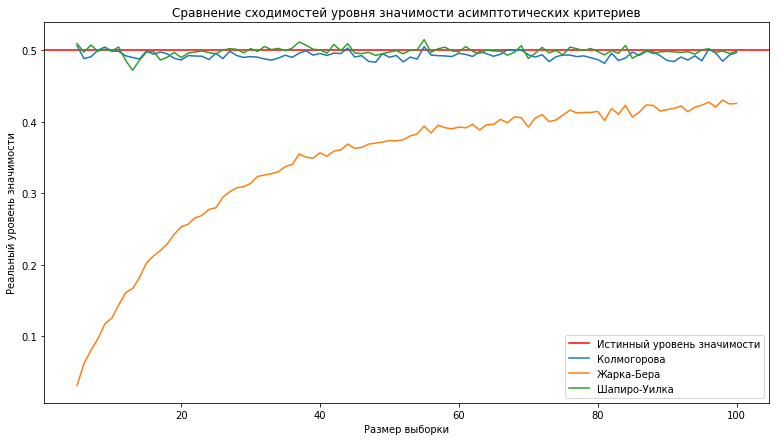

In [145]:
grid = np.arange(*sample_size_range)

plt.figure(figsize=(13, 7))
plt.title('Сравнение сходимостей уровня значимости асимптотических критериев')
plt.xlabel('Размер выборки')
plt.ylabel('Реальный уровень значимости')

plt.axhline(alpha, color='r', label='Истинный уровень значимости')
for i in range(3):
    plt.plot(grid, alpha_real[i], label=tests_name[i])
    
plt.legend()
plt.show()

Какой можно сделать вывод?

Можно заметить, что критерий Жарка-Бера даёт реальный уровень значимости меньший, чем асимптотический, в отличии от Колмогорова и Шапиро-Уилка, которые не гарантируют уровень значимости при маленьком размере выборке $< \alpha$

**2.** Аналогичным образом можно вычислять мощность критерия. Вычислите мощности критериев для размеров выборки от 5 до 100, если альтернативная гипотеза заключается в том, что выборка имеет стандартное распределение Коши. Иначе говоря, для критерия $S$ надо приближенно посчитать $\beta_S(\mathsf{P})$, где $\mathsf{P}$ --- стандартное распределение Коши.

Нарисуйте на одном графике зависимость мощности критерия от размера выборки для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [40]:
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(3)]
for i in tqdm_notebook(range(*sample_size_range)):
    for j in range(sample_count):
        sample = sps.cauchy.rvs(size=i)
        for k in range(3):
            if k == 0:
                test_result = tests[k](sample, cdf=sps.norm().cdf)
            else:
                test_result = tests[k](sample)
            
            
            is_reject[k][i, j] = test_result[1] < alpha
            
            
power_real = [0, 0, 0]
for i in range(3):
    power_real[i] = is_reject[i].sum(axis=1) / sample_count
    power_real[i] = power_real[i][sample_size_range[0] : sample_size_range[1]]

HBox(children=(IntProgress(value=0, max=96), HTML(value='')))

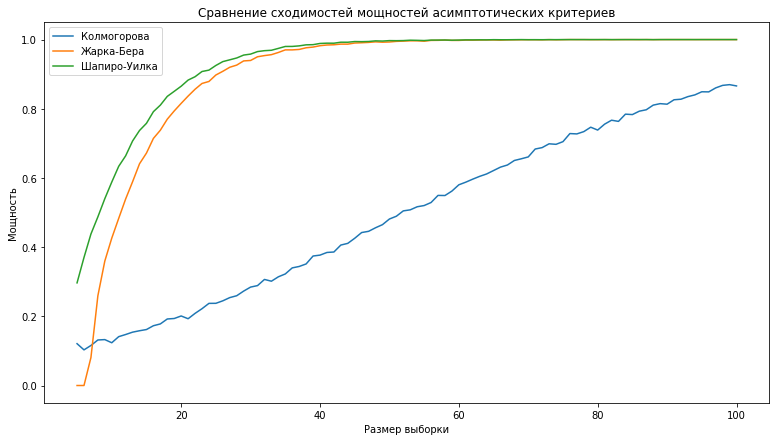

In [146]:
grid = np.arange(*sample_size_range)

plt.figure(figsize=(13, 7))
plt.title('Сравнение сходимостей мощностей асимптотических критериев')
plt.xlabel('Размер выборки')
plt.ylabel('Мощность')

for i in range(3):
    plt.plot(grid, power_real[i], label=tests_name[i])
    
plt.legend()
plt.show()

Сделайте вывод. Какой критерий является наиболее мощным при данной альтернативе?

Критерий Шапиро-Уилко имеет наибольшую мощьность, немногим опережая критерий Жарка-Бера. А критерий Колмогорова даёт слабую мощность, которая в прочем растёт при размере выборки

**3.** Распределение Стьюдента является в некотором смысле обобщением нормального распределения (при бесконечном количестве степеней свободы) и распределения Коши (при одной степени свободы). 
Посчитайте приближенно мощности критериев для выборки размера 50 если альтернатива заключается в том, что выборка имеет распределение Стьюдента. Поскольку мощность критерия является функцией от распределения из альтернативной гипотезы, вам нужно посчитать функцию. Посчитайте ее для целых значений степени свободы от 1 до 10.

Нарисуйте на одном графике зависимость мощности критерия от количества степеней свободы для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [58]:
freedom_range = (1, 10)
sample_size = 50

is_reject = [np.zeros((freedom_range[1], sample_count)) for i in range(3)]
for i in tqdm_notebook(range(*freedom_range)):
    for j in range(sample_count):
        sample = sps.t(df=i).rvs(size=sample_size)
        for k in range(3):
            if k == 0:
                test_result = tests[k](sample, cdf=sps.norm().cdf)
            else:
                test_result = tests[k](sample)
            
            
            is_reject[k][i, j] = test_result[1] < alpha
            
            
power_stud = [0, 0, 0]
for i in range(3):
    power_stud[i] = is_reject[i].sum(axis=1) / sample_count
    power_stud[i] = power_stud[i][freedom_range[0] : freedom_range[1]]

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

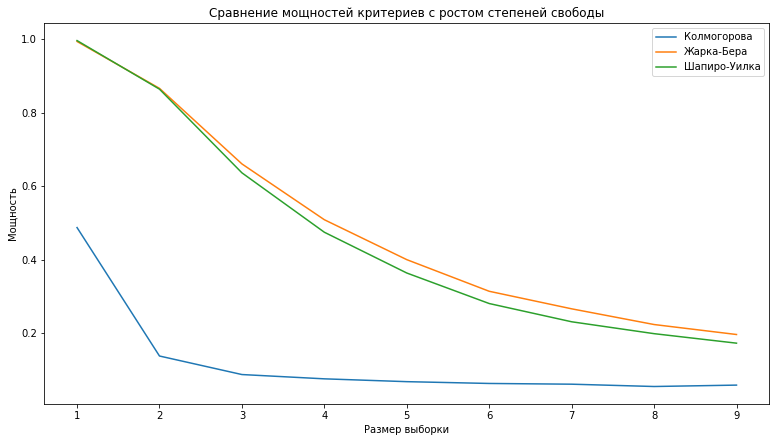

In [147]:
grid = np.arange(*freedom_range)

plt.figure(figsize=(13, 7))
plt.title('Сравнение мощностей критериев с ростом степеней свободы')
plt.xlabel('Размер выборки')
plt.ylabel('Мощность')

for i in range(3):
    plt.plot(grid, power_stud[i], label=tests_name[i])
    
plt.legend()
plt.show()

Сделайте вывод относительно мощности критерия при разных распределениях из альтернативы.

Можно заметить, что мощность уменьшается с ростом степеней свободы, так как распределение стьюдента всё больше начинает быть похожим на нормальное

**4.** Аналогичным образом посчитайте мощности критериев, если альтернативная гипотеза заключается в том, что выборка имеет экспоненциальное распределение.

In [149]:
is_reject = [np.zeros((sample_size_range[1], sample_count)) for i in range(3)]
for i in tqdm_notebook(range(*sample_size_range)):
    for j in range(sample_count):
        sample = sps.expon().rvs(size=i)
        for k in range(3):
            if k == 0:
                test_result = tests[k](sample, cdf=sps.norm().cdf)
            else:
                test_result = tests[k](sample)
            
            
            is_reject[k][i, j] = test_result[1] < alpha
            
            
power_expon = [0, 0, 0]
for i in range(3):
    power_expon[i] = is_reject[i].sum(axis=1) / sample_count
    power_expon[i] = power_expon[i][sample_size_range[0] : sample_size_range[1]]

HBox(children=(IntProgress(value=0, max=96), HTML(value='')))

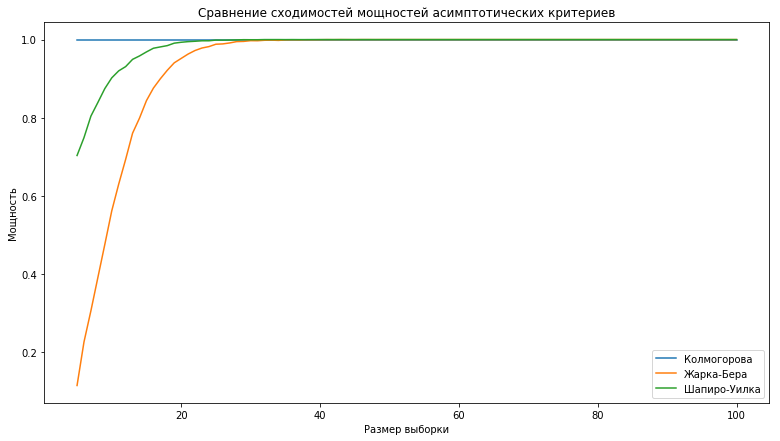

In [150]:
grid = np.arange(*sample_size_range)

plt.figure(figsize=(13, 7))
plt.title('Сравнение сходимостей мощностей асимптотических критериев')
plt.xlabel('Размер выборки')
plt.ylabel('Мощность')

for i in range(3):
    plt.plot(grid, power_expon[i], label=tests_name[i])
    
plt.legend()
plt.show()

Сделайте вывод:

Можно заметить, что в этом случае наибольшую мощность даёт критерий Колмогорова, что говорит о том, что нет универсально лучшего критерия, и для разных альтернатив нужно выбирать подходящий.

__________________
### Задача 3.


Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`.

In [99]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
column_names = [ 'Alcohol',
                 'Malic acid',
                 'Ash',
                 'Alcalinity of ash',
                 'Magnesium',
                 'Total phenols',
                 'Flavanoids',
                 'Nonflavanoid phenols',
                 'Proanthocyanins',
                 'Color intensity',
                 'Hue',
                 'OD280/OD315 of diluted wines',
                 'Proline']

# Считываем все данные
data = pd.read_csv(url, header=None, names=column_names)
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Для каждого параметра нарисуте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

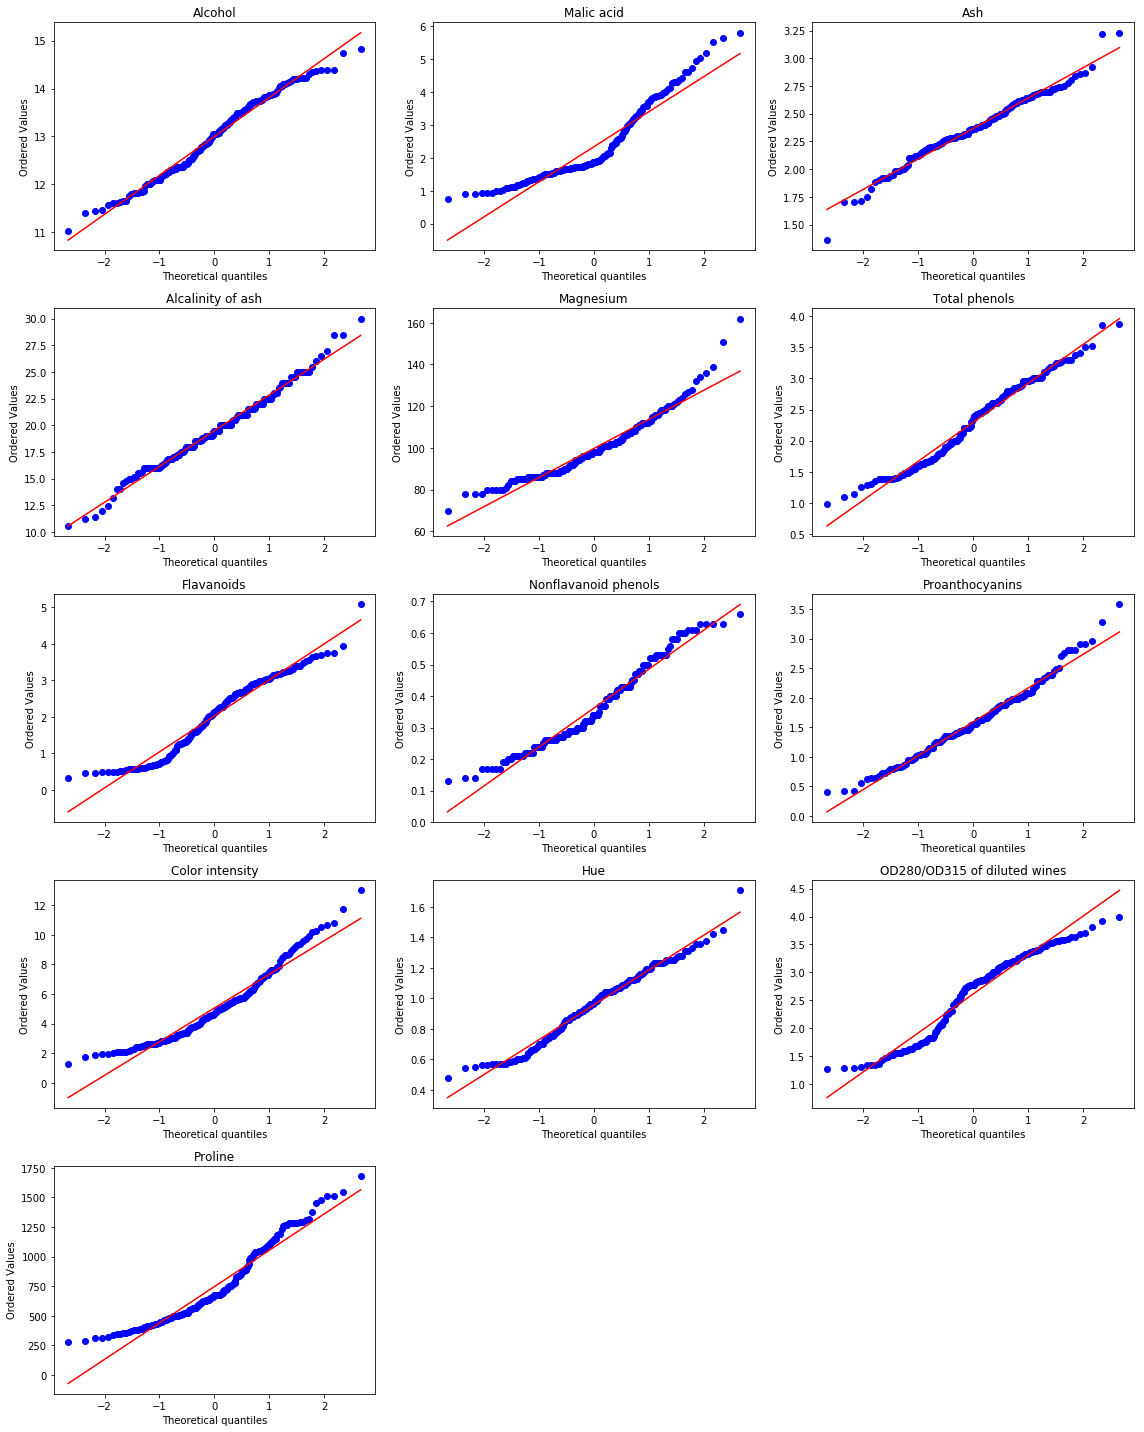

In [89]:
plt.figure(figsize=(16, 20))

for i, name in enumerate(column_names):
    plt.subplot(5, 3, i + 1)
    sps.probplot(x=data[name], dist='norm', fit=True, plot=plt)
    plt.title(name)

plt.tight_layout()

Для каких параметров можно говорить об их нормальности и почему?

**Ответ:** Можно заметить, что выборочные квантили параметров `Alcohol`, `Ash`, `Alcanity of ash`, `Proanthocyanins` и `Hue` хорошо ложатся на прямую, за исключением выбросов,а значит скорее всего имеют нормальное распределение

Проверьте нормальность каждого параметра статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы. Помочь в этом может теоретическое домашнее задание 11, разбор которого был выложен в чате.

Для каждого параметра используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** Основные критерии проверки нормальности это критерии Колмогорова, Жарка-Бера и Шапиро-Уилка. Но для применения критерия Колмогорова нужно знать параметры распределения. Поэтому буду использовать критерии Жарка-Бера и Шапиро-Уилка

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех параметров и всех критериев сразу. Почему так нужно делать?

**Ответ:** Следует использовать множественную проверку гипотез, так как мы выбираем подмножество свойств, о котором хотим сказать, что каждое свойство имеет нормальное распределение. При этом следим за вероятностью того, что мы не ошиблись ни с одним множеством ($FWER \leq \alpha$). А два критерия нужно для более точной проверки гипотиз.

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** Лучше всего подойдёт метод Холма, так как мы ничего не можем точно про зависимость свойств вина, а значит и о полученных статистик критериев.

Как понять из результата процедуры множественной проверки гипотез, нормальность каких параметров следует отклонить?

**Ответ:** Стоит отклонить нормальность тех параметров, для каторых скорректированный p-value $> \alpha$, хотя бы у одного критерия

Если нормальность не отклоняется, что можно сказать про выборку (ответ в презентации с лекции)? 

**Ответ:** В таком случае говорят, что выборка согласуется с оснновной гипотизой, а значит предположительно нормально распределена

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результат нужно собрать обратно в таблицу с помощью метода `reshape`, которому нужно передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия переменных, а названий столбцов --- используемые критерии.

In [114]:
param_num = len(column_names)
X = np.array(data[column_names]).T
tests_name = ['jarque_bera', 
              'shapiro']
tests = [sps.jarque_bera,
         sps.shapiro]

# считаем значения p-value для статистик выбраны критериев
p_for_mpt = [[tests[j](X[i])[1] for j in range(2)] for i in range(param_num)]

p_for_mpt = pd.DataFrame(p_for_mpt, index=column_names, columns=tests_name)
p_for_mpt

,jarque_bera,shapiro
Alcohol,6.106775e-02,2.005172e-02
Malic acid,1.115426e-07,2.945930e-10
Ash,8.485917e-03,3.868526e-02
Alcalinity of ash,2.509338e-01,2.638694e-01
Magnesium,6.883383e-15,6.345416e-07
Total phenols,6.312188e-02,4.395752e-03
Flavanoids,5.273120e-02,1.679064e-05
Nonflavanoid phenols,1.071359e-02,1.055266e-04
Proanthocyanins,7.840977e-03,1.445338e-02
Color intensity,1.092262e-05,9.229477e-07


In [132]:
# Применяем множественную проверку гипотез
after_mpt = multipletests(p_for_mpt.values.ravel(), method='holm')[1]
# Приводим к нужной форме
after_mpt = after_mpt.reshape((-1, 2))
# И получаем новую табличку
after_mpt = pd.DataFrame(after_mpt, index=column_names, columns=tests_name)
# А теперь проверяем гипотезы 
rejected = after_mpt <  0.05
rejected

,jarque_bera,shapiro
Alcohol,False,False
Malic acid,True,True
Ash,False,False
Alcalinity of ash,False,False
Magnesium,True,True
Total phenols,False,False
Flavanoids,False,True
Nonflavanoid phenols,False,True
Proanthocyanins,False,False
Color intensity,True,True


In [133]:
# Оставляем только те признаки, которые не отвергиются критериями
good_params = rejected.loc[rejected.jarque_bera == False]
good_params = good_params.loc[good_params.shapiro == False]
good_params

,jarque_bera,shapiro
Alcohol,False,False
Ash,False,False
Alcalinity of ash,False,False
Total phenols,False,False
Proanthocyanins,False,False
Hue,False,False


Для каких параметров нормальность не отвергается?

**Ответ:** Помимо мною названных `Alcohol`, `Ash`, `Alcanity of ash`, `Proanthocyanins` и `Hue`, нормальность не отвергается и для параметра `Total phenols`, квантили которого в целом неплохо ложатся на прямую, но меня смутила волнообразность точек.

## Линейная регрессия

__________________
### Задача 4.

По шаблону напишите класс, реализующий гауссовскую линейную регрессию. Интерфейс этого класса в некоторой степени соответствует классу <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`LinearRegression`</a> из библиотеки `sklearn`.

* Коэффициенты, полученные Методом Наименьших Квадратов:
$$\hat{\theta} = (X^\top X) ^ {-1} X^\top Y$$
* Несмещённая оценка $\sigma ^ 2$:
$$\hat{\sigma} ^ 2 = \frac{1}{n-d} ||Y - X \hat{\theta} ||^ 2$$
* Доверительный интервал для $\theta_i$ уровня доверия $\alpha$:
$$\left(\hat{\theta}_i \pm \hat{\sigma}\sqrt{(X^\top X)^{-1}_{j,j}}T_{n-d,1-\frac{\alpha}{2}}\right)$$
* Статистика критерия о незначимости коэффициента $\theta_j$:
$$T_j^0(X, Y) = \frac{\hat{\theta_j}}{\hat{\sigma}\sqrt{(X^\top X)^{-1}_{j,j}}}$$
* 

In [13]:
class LinearRegression:
    def __init__(self):
        super()
        
    def fit(self, X, Y, alpha=0.05):
        ''' Обучение модели. Предполагается модель Y = X * theta + epsilon, 
            где X --- регрессор (матрица размера n x d), 
            Y --- отклик (матрица размера n x 1),
            а epsilon имеет нормальное распределение 
            с параметрами (0, sigma^2 * I_n).
            alpha --- уровень значимости критерия 
            (1-alpha --- ур. доверия для доверительного интервала).
        '''
        
        self.alpha = alpha
        self.n, self.d = X.shape
        cool_matrix = np.linalg.inv(X.T @ X)
        
        # МНК
        self.theta = cool_matrix @ X.T @ Y
        # Несмещенная оценка для sigma^2
        self.sigma_sq = np.sum((Y - X @ self.theta) ** 2) / (self.n - self.d)
        # Корень из оценка дисперсии \theta_i
        self.stderr = np.sqrt(self.sigma_sq * np.diag(cool_matrix))
        indent = sps.t(df=self.n - self.d).ppf(1 - alpha / 2) * self.stderr
        # Доверительные интервалы для коэффициентов 
        left = self.theta - indent
        right = self.theta + indent
        # (матрица размера d x 2)
        self.conf_int = np.vstack((left, right)).T
        
        # Cтатистики критериев о незначимости коэффициентов
        self.t_stats = self.theta / self.stderr
        # p-value критериев о незначимости коэффициентов
        self.pvalue = 2 * sps.t(df=self.n-self.d).sf(abs(self.t_stats));
        
        return self
    
    def summary(self):
        print('Linear regression on %d features and %d examples' \
              % (self.d, self.n))
        print('Sigma: %.6f' % self.sigma_sq)
        
        # Далее напечатайте таблицу, 
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца), 
        # статистика критерия, p-value
        indexes = ['theta_{}'.format(i) for i in range(self.d)]
        
        col_names = ['estimation', 
                     '[{0:.2f}'.format(self.alpha/2), 
                     '{0:.2f}]'.format(1-self.alpha/2), 
                     't', 
                     'P > |t|']
        col_values = [pd.Series(self.theta, index=indexes),
                      pd.Series(self.conf_int[:,0], index=indexes),
                      pd.Series(self.conf_int[:,1], index=indexes), 
                      pd.Series(self.t_stats, index=indexes), 
                      pd.Series(self.pvalue, index=indexes)]
        
        
        df = pd.DataFrame()
        for i in range(len(col_names)):
            df[col_names[i]] = col_values[i]
        print(df)
        
        
    def predict(self, X):
        ''' Возвращает предсказание отклика на новых объектах X. '''
        
        Y_pred = X @ self.theta
        return Y_pred

Загрузите данные о потреблении мороженного в зависимости от температуры воздуха и цены (файл `ice_cream.txt`).
Примените реализованный выше класс линейной регрессии к этим данным предполагая, что модель имеет вид $ic = \theta_1 + \theta_2\ t$, где $t$ --- температура воздуха (столбец `temp`), $ic$ --- постребление мороженного в литрах на человека (столбец `IC`).
Значения температуры предварительно переведите из Фаренгейта в Цельсий [(Фаренгейт — 32) / 1,8 = Цельсий].

К обученной модели примените фунцию `summary` и постройте график регрессии, то есть график прямой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t$, где $\widehat{\theta}_1, \widehat{\theta}_2$ --- МНК-оценки коэффициентов.
На график нанесите точки выборки.

In [10]:
def get_X(attributes):
    """ Принимает список наборов d признаков
    Возвращает матрицу N x (d+1), c Добавленным столбцом константного признака"""
    
    n = len(attributes[0])
    # Превращаем константы в массивы
    for i in range(len(attributes)):
        attributes[i] = np.ones(n) * attributes[i]
        
    attributes.insert(0, np.ones_like(attributes[0]))
    return np.vstack(attributes).T

In [11]:
data = pd.read_csv('ice_cream.txt', delimiter='\t')
data.temp = (data.temp-32) / 1.8
data.head()

,date,IC,price,income,temp,Lag-temp,Year
0,1,0.386,0.270,78,5.000000,56,0
1,2,0.374,0.282,79,13.333333,63,0
2,3,0.393,0.277,81,17.222222,68,0
3,4,0.425,0.280,80,20.000000,69,0
4,5,0.406,0.272,76,20.555556,65,0


In [14]:
l_reg = LinearRegression()

X = get_X([data.temp.values, ])
Y = data.IC.values
l_reg.fit(X, Y).summary()

Linear regression on 2 features and 30 examples
Sigma: 0.001786
         estimation     [0.03     0.97]          t       P > |t|
theta_0    0.306298  0.283276  0.329319  27.253231  1.060446e-21
theta_1    0.005593  0.003831  0.007355   6.502305  4.789215e-07


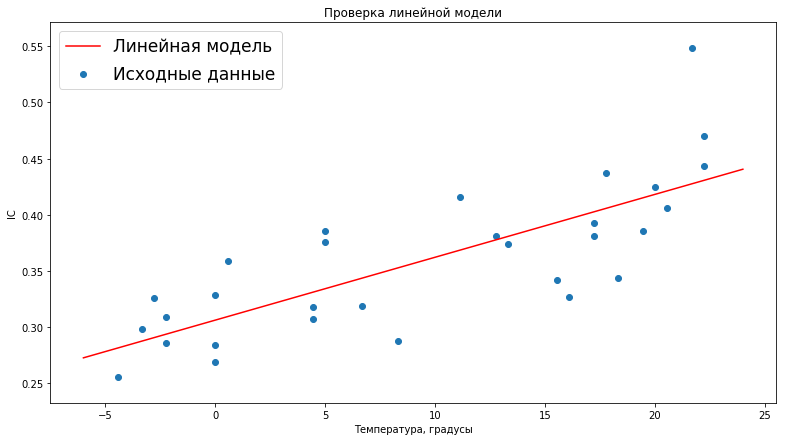

In [16]:
t_s = np.linspace(-6, 24, 600)

plt.figure(figsize=(13, 7))
plt.title('Проверка линейной модели')

plt.scatter(data.temp, Y, label='Исходные данные')
plt.plot(t_s, l_reg.predict(get_X([t_s, ])), color='red', label='Линейная модель')

plt.xlabel('Температура, градусы')
plt.ylabel('IC')
plt.legend(fontsize=17)
plt.show()

Теперь учтите влияние года (столбец `Year`) для двух случаев:
* модель $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$, где $y_1 = I\{1\ год\}, y_2 = I\{2\ год\}$. Поясните, почему нельзя рассмативать одну переменную $y$ --- номер года.
* для каждого года рассматривается своя линейная зависимость $ic = \theta_1 + \theta_2\ t$.

В каждом случае нарисуйте графики. Отличаются ли полученные результаты? От чего это зависит? Как зависит потребление мороженного от года? 

**Решение:** Сначала проведём обучение моделий
* первый случай: модель $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$

In [242]:
# добавим два столбца - индикаторы 1-го и 2-го года соответственно
data['first_year'] = (data.Year == 1).astype(int)
data['second_year'] = (data.Year == 2).astype(int)

first_case_regression = LinearRegression()
X = get_X(list(data[['temp', 'first_year', 'second_year']].values.T))
Y = data.IC.values

first_case_regression.fit(X, Y)
first_case_regression.summary()

Linear regression on 4 features and 30 examples
Sigma: 0.001016
         estimation     [0.25     0.75]          t       P > |t|
theta_0    0.277050  0.251176  0.302923  22.010266  1.233144e-18
theta_1    0.006095  0.004741  0.007449   9.251310  5.223268e-10
theta_2    0.016491 -0.011237  0.044218   1.222508  1.162413e-01
theta_3    0.074307  0.041535  0.107078   4.660736  4.115334e-05


* второй случай: модель $ic = \theta_1 + \theta_2\ t$ для каждого года

In [243]:
second_case_regressions = []
for i in range(3):
    reg = LinearRegression()
    curr_data = data[data.Year == i]
    
    X = get_X([curr_data.temp,])
    Y = curr_data.IC.values
    reg.fit(X, Y)
    print('----------------------------------------------------------------')
    reg.summary()
    second_case_regressions.append(reg)

----------------------------------------------------------------
Linear regression on 2 features and 10 examples
Sigma: 0.001597
         estimation     [0.25     0.75]          t       P > |t|
theta_0    0.286405  0.236963  0.335846  13.358176  4.716470e-07
theta_1    0.005277  0.001787  0.008767   3.486794  4.118535e-03
----------------------------------------------------------------
Linear regression on 2 features and 13 examples
Sigma: 0.000667
         estimation     [0.25     0.75]          t       P > |t|
theta_0    0.297426  0.274993  0.319859  29.181668  4.503029e-12
theta_1    0.005672  0.003935  0.007409   7.185698  8.924880e-06
----------------------------------------------------------------
Linear regression on 2 features and 7 examples
Sigma: 0.000766
         estimation     [0.25     0.75]          t       P > |t|
theta_0    0.338346  0.303805  0.372886  25.180180  9.218679e-07
theta_1    0.007877  0.004907  0.010846   6.817778  5.173981e-04


А теперь проведём *грандиозное* сравнение этих моделей. Построим три графика, в $i$-ом:
 * Производится сравнение первой модели и второй модели для $i$-го года 
 * Для $i$-го года отображается соответствующая выборка
 * Вторые модели для других лет наносятся фоном, пунктирной линией

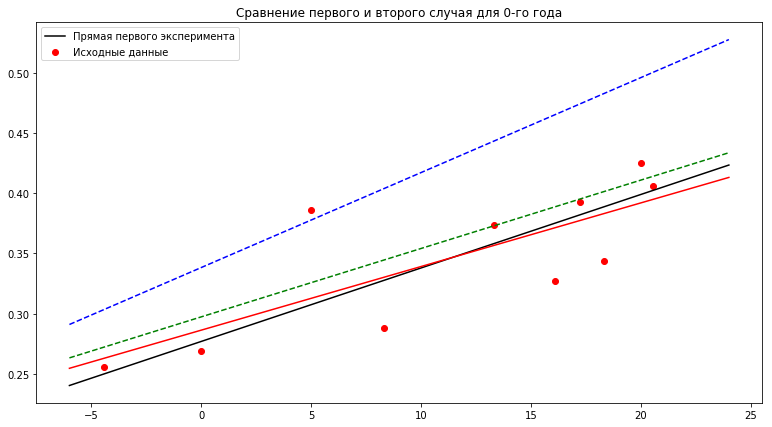

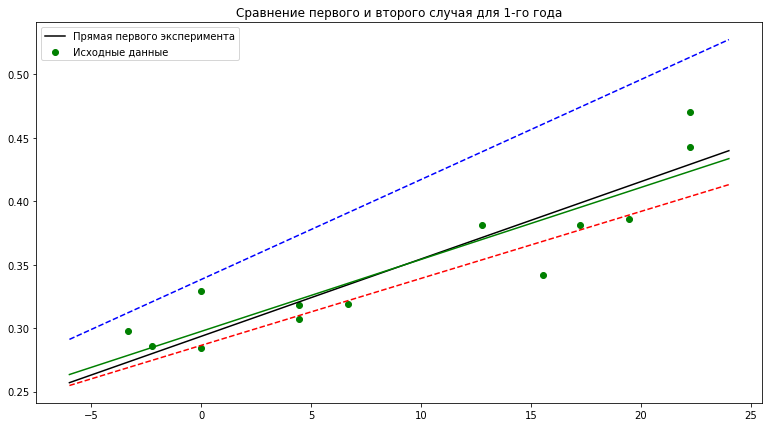

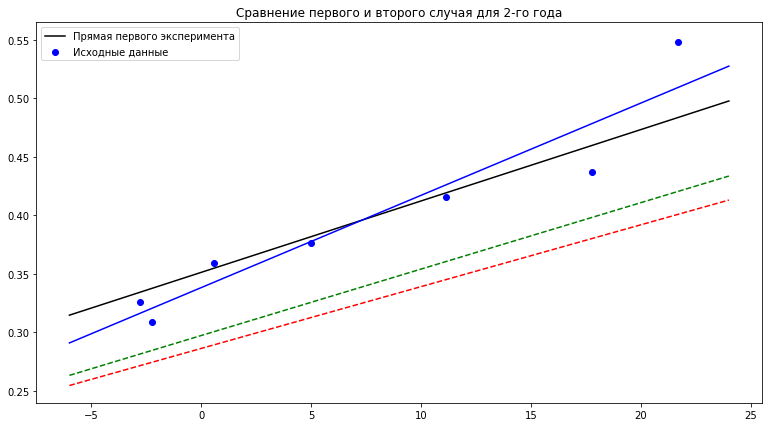

In [258]:
colors = ['r', 'g', 'b']
t_s = np.linspace(-6, 24, 600)

# Нанесём точки выборки для каждого года
for y in range(3):
    curr_data = data[data.Year == y]
    
    plt.figure(figsize=(13, 7))
    plt.title('Сравнение первого и второго случая для {}-го года'.format(y))
    # Наносим прямую первой модели
    X = get_X([t_s, y == 1, y == 2])
    plt.plot(grid, first_case_regression.predict(X), 
             color='black', label='Прямая первого эксперимента')
    
    # Наносим прямую второй модели из y-го года
    X = get_X([t_s, ])
    plt.plot(grid, second_case_regressions[y].predict(X), color=colors[y])
    # Отображаем выборку 
    plt.scatter(curr_data.temp, curr_data.IC,
                color=colors[y], label='Исходные данные')
    
    # Отображаем остальные две прямые:
    for ny in range(3):
        if y == ny:
            continue
        
        curr_data = data[data.Year == ny]
        X = get_X([t_s, ])
        plt.plot(grid, second_case_regressions[ny].predict(X),
                 color=colors[ny], ls='--')
    
    plt.legend()
    plt.show()


Наконец, обучите модель на предсказание потребления мороженного в зависимости от всех переменных.
Не забудьте, что для года нужно ввести две переменных.
Для полученной модели выведите `summary`.

In [260]:
X = data.drop(['date', 'Year', 'IC'], axis=1).values
Y = df.IC.values

l_reg = LinearRegression()
l_reg.fit(X, Y)
l_reg.summary()

Linear regression on 6 features and 30 examples
Sigma: 0.001233
         estimation     [0.25     0.75]         t       P > |t|
theta_0    1.042379 -0.145322  2.230081  1.811368  4.130924e-02
theta_1   -0.000038 -0.004028  0.003951 -0.019827  5.078275e-01
theta_2    0.006460  0.004574  0.008346  7.069918  1.308066e-07
theta_3   -0.000180 -0.001113  0.000753 -0.397332  6.526827e-01
theta_4    0.010091 -0.023702  0.043884  0.616320  2.717429e-01
theta_5    0.078241  0.007848  0.148635  2.294010  1.542204e-02


Но это еще не все.
Постройте теперь линейную регрессию для модели $ic = \theta_1 + \theta_2\ t + \theta_3\ t^2 + \theta_4\ t^3$.
Выведите для нее summary и постройте график предсказания, то есть график кривой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t + \widehat{\theta}_3\ t^2 + \widehat{\theta}_4\ t^3$. Хорошие ли получаются результаты?

In [263]:
temp = data.temp.values
X = get_X([temp, temp ** 2, temp ** 3])
Y = data.IC.values

# Обучаем модель (Но не для этого она ведь рождена!)
l_reg = LinearRegression()
l_reg.fit(X, Y)
l_reg.summary()

Linear regression on 4 features and 30 examples
Sigma: 0.001529
         estimation     [0.25     0.75]          t       P > |t|
theta_0    0.319902  0.295294  0.344510  26.721959  9.786137e-21
theta_1    0.007200  0.000388  0.014013   2.172538  1.955882e-02
theta_2   -0.000855 -0.001861  0.000152  -1.745679  9.536623e-01
theta_3    0.000038  0.000002  0.000073   2.180118  1.924604e-02


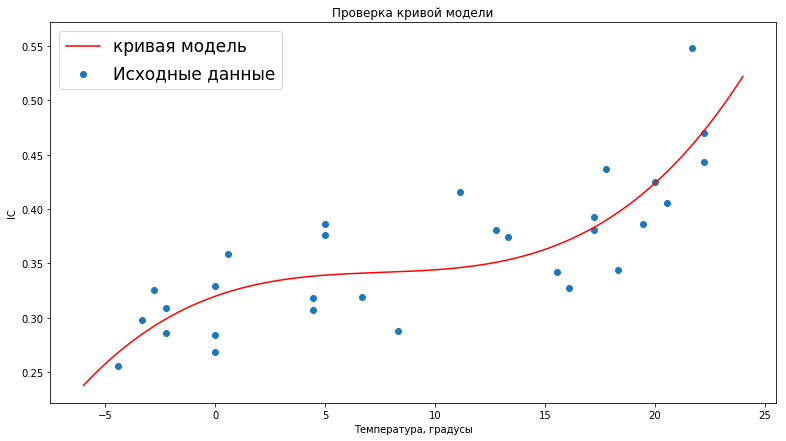

In [265]:
t_s = np.linspace(-6, 24, 600)

plt.figure(figsize=(13, 7))
plt.title('Проверка кривой модели')

plt.scatter(data.temp, Y, label='Исходные данные')
X = get_X([t_s, t_s ** 2, t_s ** 3])
plt.plot(grid, l_reg.predict(X), color='red', label='кривая модель')

plt.xlabel('Температура, градусы')
plt.ylabel('IC')
plt.legend(fontsize=17)
plt.show()

 - Да, модель кривая... И хорошо описывает данные, но можно заметить, что коэффициенты достаточно малы и есть подозрение, что это из-за переобучения

Чтобы понять, почему так происходит, выведите значения матрицы $(X^T X)^{-1}$ и посчитайте для нее индекс обусловленности $\sqrt{\left.\lambda_{max}\right/\lambda_{min}}$, где $\lambda_{max}, \lambda_{min}$ --- максимальный и минимальный собственные значения матрицы $X^T X$. Собственные значения можно посчитать функцией <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigvals.html">`scipy.linalg.eigvals`</a>.

Прокомментируйте полученные результаты. Помочь в этом может следующая <a href="https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%BE%D0%B1%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8">статья</a>.

In [266]:
eigvals = np.linalg.eigvals(np.linalg.inv(X.T @ X))
print("Индекс обусловленности есть - %.5f" %np.sqrt(max(eigvals) / min(eigvals)))

Индекс обусловленности есть - 8125.68889


**Вывод:** Действительно очень похоже, что модель переобучена так как матрица близка к вырожденной и максимальное и минимальное собственные числа сильно отличаются

__________________
### Задача 5.

В данной задаче нужно реализовать функцию отбора признаков для линейной регрессии. Более подробно, пусть у объектов есть признаки $x_1, ... , x_k$. Нужно определить, какое подмножество признаков $x_{j_1}, ... , x_{j_s}$ нужно использовать, чтобы качество полученной модели $y = \theta_0 + \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$ было максимальным.

Один из методов, решающих эту задачу описан ниже.

Сначала имеющаяся выборка случайно разделяется на обучающую выборку и тестовую (train и test). Для некоторого подмножества признаков на обучающей выборке обучается модель, после чего вычисляется её качество на тестовой выборке. Операция повторяется для всех подмножеств признаков. Лучшей считается модель с наилучшим качеством на тестовой выборке.

Иначе говоря, сначала выборка $X$ разделяется по объектам на $X_{train} \sqcup X_{test} = X$ . Далее, в цикле по всем подмножествам индексов признаков $(j_1, .. j_s)$ на обучающей выборке $X_{train}$ обучается модель $y = \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$, после чего считается её качество на $X_{test}$.

В данной задаче под метрикой качества понимается средний квадрат ошибки (mean squared error)

$$MSE = \frac{1}{n} \sum\limits_{x \in X_{test}} \left(\widehat{y}(x) - Y(x)\right)^2,$$
где $x$ -  объект, $Y(x)$ - значение целевой переменной (отклика) на объекте $x$, а $\widehat{y}(x)$ - оценка отклика на объекте $x$.

Заметим, что полный перебор подмножеств признаков требует большого времени. Кратко проблема отбора признаков состоит в том, что могут быть два признака, добавление каждого из которых ухудшает (не улучшает) качество, но добавление двух признаков сразу увеличивает качество.

Для выполнения задания воспользуйтесь следующими функциями:
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`sklearn.linear_model.LinearRegression`</a>
--- реализация линейной регрессии. В данной реализации свободный параметр $\theta_1$ по умолчанию автоматически включается в модель. Отключить это можно с помощью `fit_intercept=False`, но это не нужно. *В данной задаче требуется, чтобы вы воспользовались готовой реализацией линейной регрессии, а не своей. Ведь на практике важно уметь применять готовые реализации, а не писать их самостоятельно.*

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`sklearn.model_selection.train_test_split`</a>
--- функция разбиения данных на train и test. Установите параметр `test_size=0.3` и `random_state=17`.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">`sklearn.metrics.mean_squared_error`</a>
--- реализация MSE.

Для перебора реализуйте следующий класс. Данный класс частично реализует интерфейс, похожий на интерфейс <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">`sklearn.model_selection.GridSearchCV`</a>

In [ ]:
class BestFeaturesSelection:
    def __init__(self, estimator, scoring, parameters=dict(), 
                 test_size=0.3, random_state=17, minimize=True):
        """
        Отбор наилучших признаков
        estimator: конструктор класса, например, LinearRegression
        paramters: параметры, передаваемые конструктору estimator, 
                    например dict(fit_intercept=False)
        scoring: функция риска, например, mean_squared_error
        minimize: минимизировать ли функционал качества 
                    (иначе - максимизировать)
        """
        
        self.estimator = estimator
        self.parameters = parameters
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        self.minimize=minimize
        
    def fit(self, X, y):
        """
        Подбор лучшего подмножества признаков 
        и обучение модели на нём
        """
        
        # разделение выборки на test и train. Не перепутайте порядок !
        X_train, X_test, y_train, y_test = <...>
        
        self.results_ = []  # список пар (вектор использованных признаков, 
                            # значение функции потерь)
        features_count = X.shape[1]
        
        for bitmask in range(1, 2 ** features_count):
            subset = [i == "1" for i in np.binary_repr(bitmask, 
                                                       width=features_count)]
            # binary_repr возвращает строку длины width с двоичным 
            # представлением числа и ведущими нулями
            
            score = <...>  # вычисление качества модели
    
            self.results_.append((subset, score))
        
        self.results_.sort(key = lambda pair: pair[1],
                           reverse=not self.minimize) 
        # сортируем по второму элементу в нужном порядке
        
        self._best_subset = self.results_[0][0]
        self._best_estimator = self.estimator(**self.parameters)
        self._best_estimator.fit(X_train[:, self._best_subset], y_train)
        
        return self._best_estimator
        
    def predict(self, X):
        """
        Предсказание модели, 
        обученной на наилучшем подмножестве признаков.
        """
        
        return self._best_estimator.predict(X[:, self._best_subset]);

Примените реализованный отбор признаков к датасетам
* <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a> --- для парусных яхт нужно оценить остаточное сопротивление на единицу массы смещения (последний столбец) в зависимости от различных характеристик яхты.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">Boston Housing Prices</a> --- цены на дома в Бостоне в зависимости от ряда особенностей.

Посмотрите на графики зависимости целевой переменной от каждого признака. Какие бы признаки вы стали использовать? Совпадает ли ваш выбор с результатом алгоритма, описанного выше? 

In [ ]:
# место для вашего решения

__________________
### Задача 6.

Рассмотрим модель $Y = X \theta + \varepsilon$, где $X \in \mathbb{R}^{n \times k}$ --- регрессор, $Y \in \mathbb{R}^{n \times 1}$ --- отклик, а $\varepsilon \sim \mathcal{N}(0, \beta^{-1}  I_n)$. При классической постановке задачи линейной регрессии оценка параметра $\theta$ находится минимизацией остаточной суммы квадратов ($RSS = \|Y - X\theta\|^2$) и равна $ \overset{\wedge}{\theta} = (X^{т}X)^{-1}X^{т}Y$. Часто также рассматривают регуляризацию, эквивалентную баесовской остановке задачи. Если в качестве априорного на $\theta$ взять $\mathcal{N}(0, \alpha^{-1}I_k)$, то оценкой параметра является математическое ожидание апостериорного распределения (которое в данном случае она совпадает с модой) $\overset{\wedge}{\theta} = \left(X^{т}X + \frac{\alpha}{\beta}I_k\right)^{-1}X^{т}Y$. Такая постановка задачи соответствует случаю Ridge-регрессии. Если же $\theta$ имеет в качестве априорного распределение Лапласа, то оценкой параметра является мода апостерионого распределения. Данная постановка задачи соответствует случаю Лассо регрессии и не решается аналитически.

При выполнении задания воспользуйтесь готовыми реализациями:
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`sklearn.linear_model.LinearRegression` </a>

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">`sklearn.linear_model.RidgeRegression`</a>

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html">`sklearn.linear_model.LassoRegression`</a>

В обоих случаях свободный параметр автоматически включается в модель, отключить это можно с помощью `fit_intercept=False`. В случае Ridge и Lasso регрессии параметр `alpha` отвечает за регуляризацию, по умолчанию он принимает значение 1.0. В обозначениях выше для Ridge-регрессии `alpha` $= \frac{\alpha}{\beta}$.


Для выполнения задания скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018` </a>, в которых используйте следующие столбцы:
* `Cost of Living Index` --- является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` --- это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` --- это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` --- сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` --- показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` --- это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров.

Для начала исследуйте зависимость значений коэффициентов от параметра регуляризации для Ridge и Lasso регрессии. Для этого в обоих случаях постройте график значений каждого из коэффициентов в зависимости от параметра регуляризации `alpha` из реализации `sklearn`. Для Ridge-регрессии в качестве значений параметра рекомендуется брать отрезок от 0 до примерно 0.3-0.5. Для Lasso от 0 до 600-800.

In [ ]:
<...>

Расчитайте индекс обусловленности для случая линейной регрессии. Исследуйте зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии.

In [ ]:
<...>

Перейдем к более практической части. Разбейте исходную выборку на обучающую и тестовую (в этом поможет функция <a href="http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html">`train_test_split` </a> из библиотеки `sklearn`), обучив модель на одной части, постройте предсказание для другого куска для случаев линейной регрессии, Ridge и Lasso. Посчитайте среднеквадратичную ошибку (<a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">`mean_squared_error` </a> также из библиотеки `sklearn`).

In [ ]:
<...>

Исследуйте зависимость среднеквадратичной ошибки от параметра регуляризации для случаев Ridge и Lasso регрессии. Найдите оптимальное значение параметра для конкретного разбиения.

In [ ]:
<...>